In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq

In [14]:
# Setting image settings
plt.rcParams.update({'font.size': 16})

In [15]:
# SMALL_SIZE = 10
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 20

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [16]:
class advection:
    
    def __init__(self, method):
        self.method = method

    def initial_condition(self,x,c0=10):
            if x < 1125e3 or x > 1375e3:
                return 0
            else:
                return c0

    def solve_advection_equation(self,dx=25e3,dt=1000,L=2500e3,T=160*3600,u0=10):
        '''
        Function to solve linear advection equation in x and time

        INPUT:
        Method: either Euler or Lax-Wendroff method to solve ODE
        dx = steps in x in m
        dt = timesteps in s
        L = basin length in m
        T = time duration of simulation
        u0 = initial velocity

        OUTPUT:
        C = 2D vector in [time,space]
        '''
        # Create the grid
        x = np.arange(0, L, dx)
        t = np.arange(0, T, dt)

        # Initialize the solution matrix
        C = np.zeros((len(t), len(x)))

        # Set the initial condition
        for j in range(len(x)):
            C[0,j] = self.initial_condition(x[j])

        # Compute the solution using the specified difference integration method
        if self.method == 'Euler':
            for i in range(len(t)-1):
                for j in range(1, len(x)):
                    C[i+1,j] = C[i,j] - (u0*dt/dx)*(C[i,j]-C[i,j-1])
                    # Apply periodic boundary conditions
                C[i+1,0] = C[i+1,-2]
                C[i+1,-1] = C[i+1,1]
            print(u0*dt/dx)
        elif self.method == "Lax-Wendroff":
            for i in range(len(t)-1):
                for j in range(1, len(x)-2):
                    C[i+1,j] = C[i,j]-(u0*dt/(2*dx)) * ((C[i,j+1]-C[i,j-1])) + 0.5*(np.square(u0)*np.square(dt)/np.square(dx))*(C[i,j+1]-2*C[i,j]+C[i,j-1]) 
                # Apply periodic boundary conditions
                C[i+1,0] = C[i+1,-3]
                C[i+1,-2] = C[i+1,1]
            print(u0*dt/dx)

        return C


In [17]:
ad1 = advection('Euler')
C_Euler = ad1.solve_advection_equation()

ad2 = advection('Lax-Wendroff')
C_Lax = ad2.solve_advection_equation()



0.4
0.4


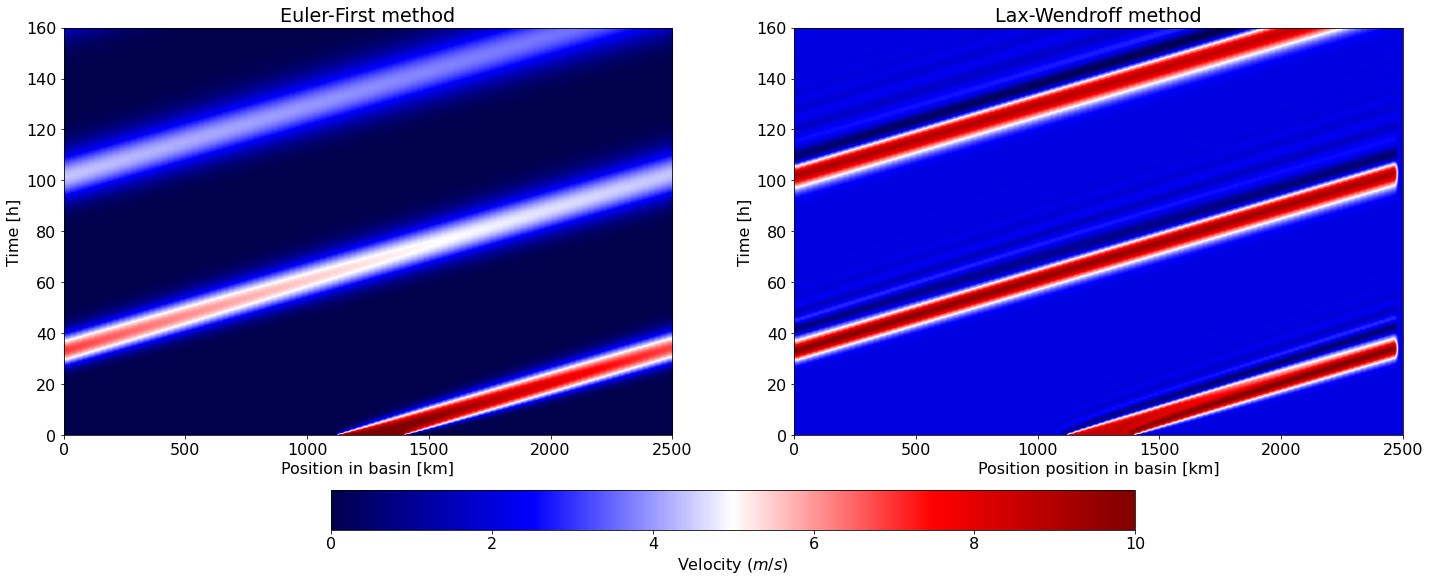

In [34]:
# Plot the solution
fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)

# First subplot
im1 = axs[0].imshow(C_Euler, aspect='auto', cmap='seismic', origin='lower', extent=[0, 2500e3/1e3, 0, 160*3600/3600])
axs[0].set_xlabel('Position in basin [km]')
axs[0].set_ylabel('Time [h]')
axs[0].set_title('Euler-First method')

# Second subplot
im2 = axs[1].imshow(C_Lax, aspect='auto', cmap='seismic', origin='lower', extent=[0, 2500e3/1e3, 0, 160*3600/3600])
axs[1].set_xlabel('Position position in basin [km]')
axs[1].set_ylabel('Time [h]')
axs[1].set_title('Lax-Wendroff method')

# Add a colorbar for both subplots
cbar = fig.colorbar(im1, ax=axs, location='bottom', pad=0.1,shrink=0.6, label='Velocity $(m/s)$')


plt.show()


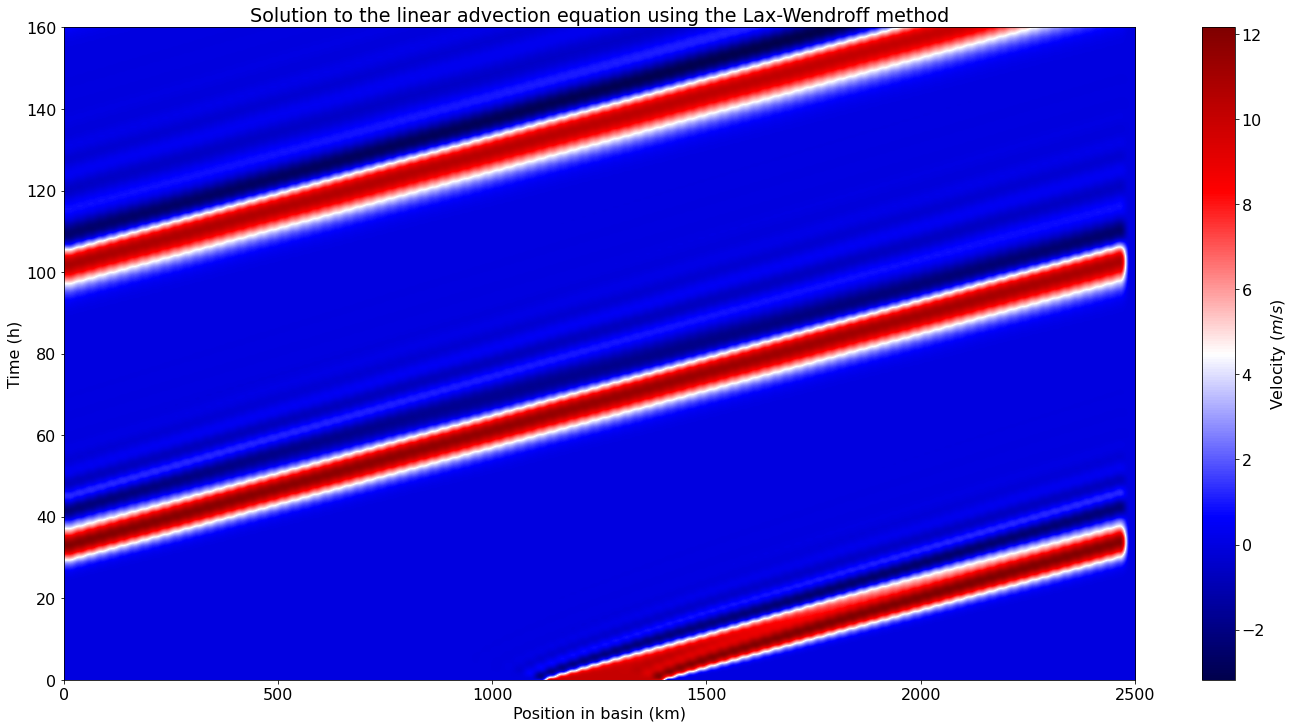

In [32]:
plt.figure(figsize=(24,12))
plt.imshow(solve_advection_equation('Lax-Wendroff'), aspect='auto', cmap='seismic', origin='lower', extent=[0, 2500e3/1e3, 0, 160*3600/3600])
plt.colorbar(label='Velocity ($m/s$)')
plt.xlabel('Position in basin (km)')
plt.ylabel('Time (h)')
plt.title('Solution to the linear advection equation using the Lax-Wendroff method')
plt.show()

## Spectral Method


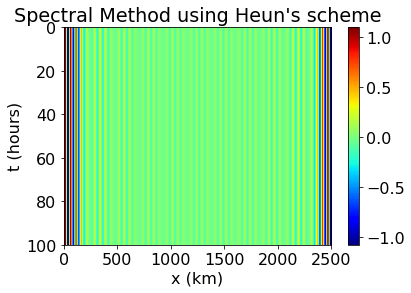

In [7]:


# Define the grid parameters
dx = 25e3    # Spatial step size
dt = 2000    # Temporal step size
L = 2500e3   # Domain length
T = 100*3600 # Simulation time

# Define the velocity and initial condition
u = 10 # m/s
c0 = 10

def initial_condition(x):
        if x < 1125e3 or x > 1375e3:
            return 0
        else:
            return c0

# Create the grid
x = np.arange(0, L, dx)
t = np.arange(0, T, dt)

# Compute the wavenumber
k = fftfreq(len(x), dx)

# Initialize the solution matrix
C = np.zeros((len(t), len(x)))

for j in range(len(x)):
    C[0,j] = initial_condition(x[j])
    
    
# Define the spectral operator
L_op = -(u/L)*2j*np.pi*k

# Compute the solution using the Heun's scheme
for i in range(len(t)-1):
    # First step of Heun's scheme
    C_hat = fft(C[i,:])
    C_tilde = (C_hat + L_op*C_hat)
    C_tilde = np.real(ifft(C_tilde))
    # Second step of Heun's scheme
    C_hat_tilde = fft(C_tilde)
    C[i+1,:] = np.real(ifft(0.5*(C_hat + C_hat_tilde + dt*L_op*C_hat_tilde)))
    
    #Apply periodic boundary conditions
    C[i+1,0] = C[i+1,-2]
    C[i+1,-1] = C[i+1,1]
    
    
C_physical = np.real(ifft(C, axis=1))

C_sol = np.zeros((len(x), len(t)))

# for idx, val in enumerate(C):
#     pred_c = -dt*2j*np.pi*u*val/L + val
#     C_sol[:,idx] = np.real((-dt*2j*np.pi*u*val/L * pred_c + val)*dt)


# Plot the solution
plt.imshow(C_physical, cmap='jet', aspect='auto', extent=[0, L/1e3, T/3600, 0])
plt.colorbar()
plt.xlabel('x (km)')
plt.ylabel('t (hours)')
plt.title('Spectral Method using Heun\'s scheme')
plt.show()


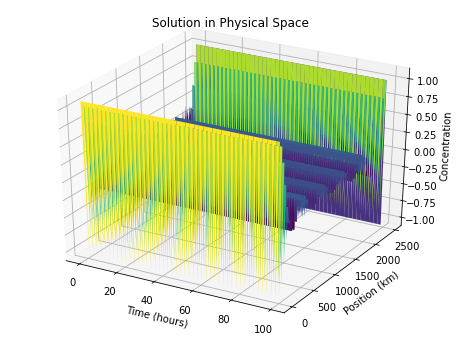

In [8]:
%matplotlib inline

T, X = np.meshgrid(t, x)


# Plot the 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T/3600, X/1e3, C_physical.T, cmap='viridis')
# ax.plot_surface(T/3600, X/1e3, C.T, cmap='viridis')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Position (km)')
ax.set_zlabel('Concentration')
ax.set_title('Solution in Physical Space')
plt.show()

In [9]:
def spectral(dx=25e3,dt=2000,L=2500e3,T=36e4,u=10,c0=10):
    N = L/dx
    # Create the grid
    x = np.arange(0, L, dx)
    t = np.arange(0, T, dt)

    
  
    
    
    
    # Compute the wavenumber
    k_f = fftfreq(len(x), dx) 
  
    
    # Initialize the solution matrix
    C = np.zeros((len(t), len(x)))

    for j in range(len(x)):
        C[0,j] = initial_condition(x[j])
    
    
    # Define the spectral operator
    L_op = -(u/L)*2j*np.pi*k_f
    
    for idx, k in enumerate(k_f):
        C[0,idx] = k
    
    print(L_op)
    
    
    
    for i in range(len(t)-1):
    # First step of Heun's scheme
        C_hat = fft(C[i,:])
        dcdt = C_hat * L_op
        ck = np.real(ifft(dcdt)) #Inverse fourier transform to 
        cstar = (L_op*ck + ck)*dt
        C[i+1,:] = (L_op*cstar + ck)*dt
        
    
    
    return C




In [10]:
print(2500e3/25e3)
# spectral()

100.0


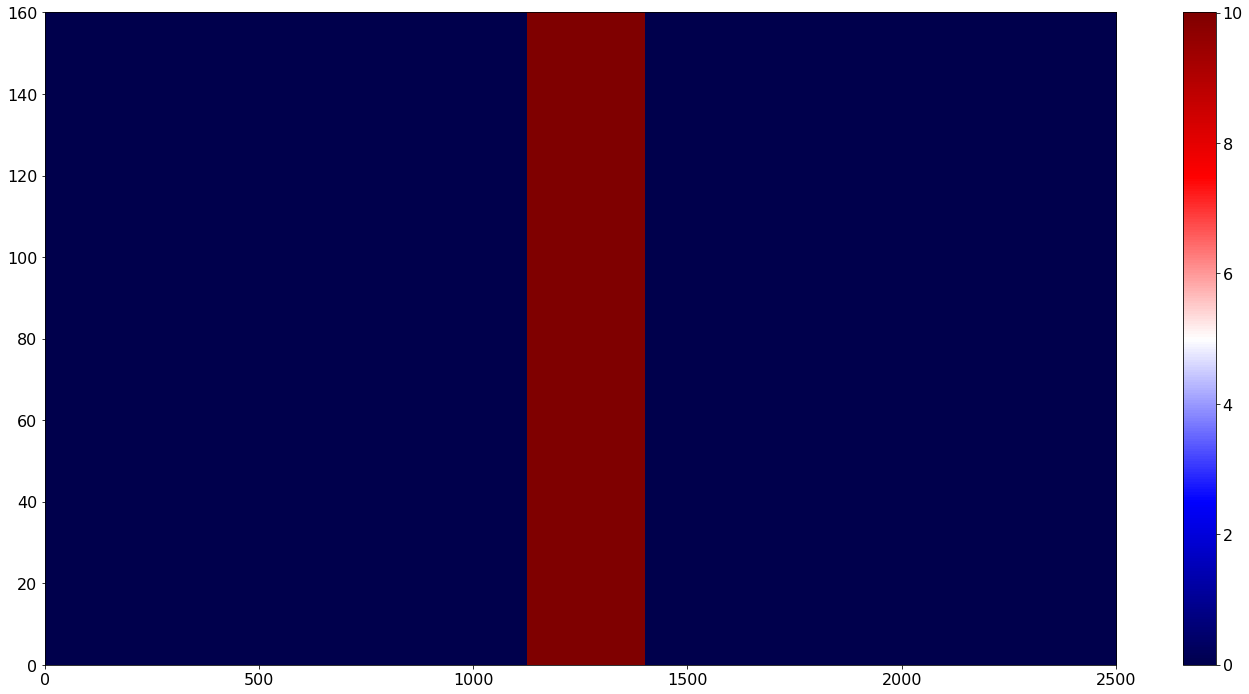

In [57]:
# Import necessary libraries
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

# Define the grid parameters
dx = 25e3    # Spatial step size
dt = 2000    # Temporal step size
L = 2500e3   # Domain length
T = 100*3600 # Simulation time

# Define the velocity and initial condition
u = 10 # m/s
c0 = 10

# Define the initial condition function
def initial_condition(x):
    if x < 1125e3 or x > 1375e3:
        return 0
    else:
        return c0

# Create the grid
x = np.arange(0, L, dx)
t = np.arange(0, T, dt)

# Compute the wavenumber
k = fftfreq(len(x), dx)

# Initialize the solution matrix
C = np.zeros((len(t), len(x)))

for j in range(len(x)):
    C[0,j] = initial_condition(x[j])
    
# Define the spectral operator
L_op = -(u/L)*2j*np.pi*k

# Compute the solution using the Matsuno scheme
for i in range(len(t)-1):
    # First step of Matsuno scheme
    C_hat = fft(C[i,:])
    C_tilde = C_hat  - 2*dt*L_op*C_hat
    
    # Second step of Matsuno scheme
    C_tilde_2 = C_tilde - 2*dt*L_op*C_tilde
    C_tilde_2 = np.real(ifft(C_tilde_2))
    
    C[i+1,:] = C_tilde_2 #Using matsuno in time
    
    # Apply periodic boundary conditions
    C[i+1,0] = C[i+1,-2]
    C[i+1,-1] = C[i+1,1]
    
# Create the contour plot


plt.figure(figsize=(24,12))
plt.imshow(C, aspect='auto', cmap='seismic', origin='lower', extent=[0, 2500e3/1e3, 0, 160*3600/3600])
cbar = plt.colorbar()



Text(0.5, 0, 'X[KM]')

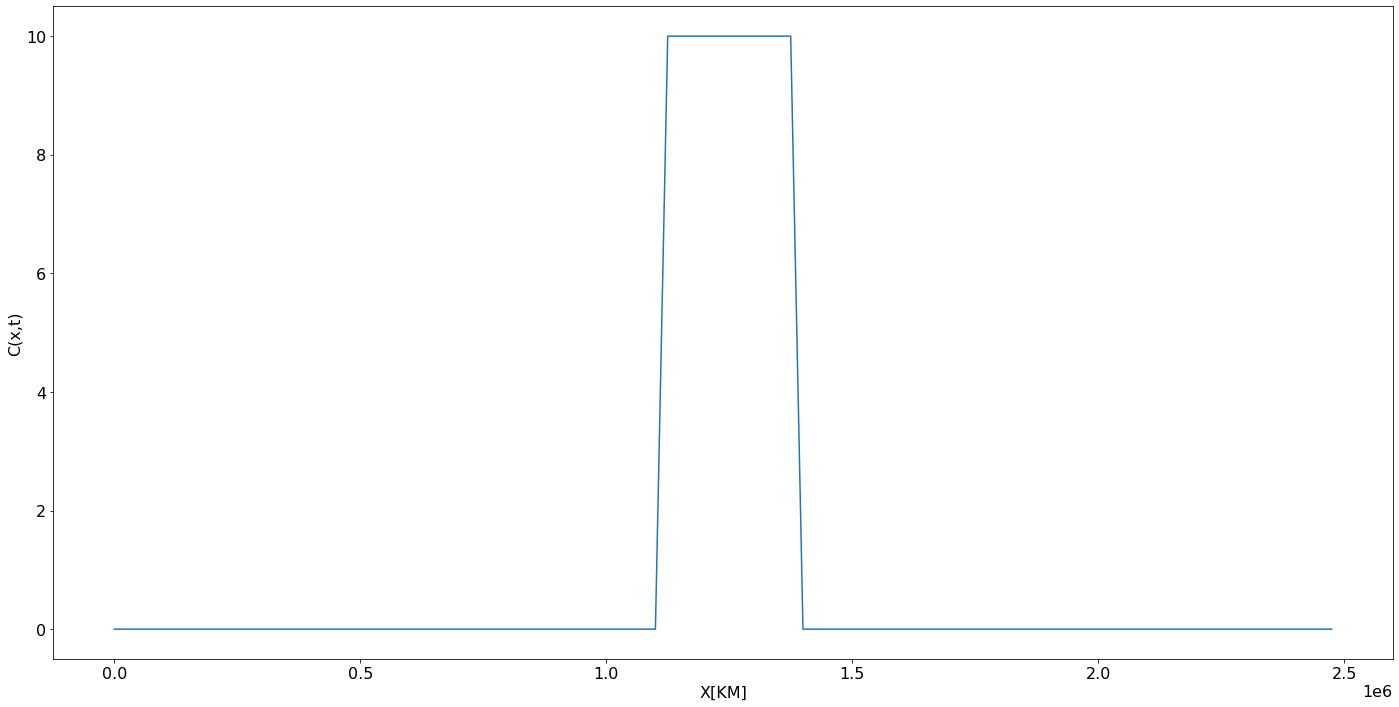

In [73]:
fig, ax = plt.subplots(figsize=(24,12), nrows=1, ncols=1)

ax.plot(x,C[0])
ax.set_ylabel('C(x,t)')
ax.set_xlabel('X[KM]')


In [74]:
np.shape(C)

(180, 100)